In [1]:
#!pip install https://github.com/pystruct/pystruct/archive/master.zip
#!pip install cvxopt

In [2]:
import numpy as np
import matplotlib.pyplot as plt

$X = (x_1, x_2, ..., x_T)$

$H = (h_1, h_2, ..., h_T)$

$$p(X,H) = p(x_1 | h_1)p(h_1)\prod_{t=2}^T p(x_t | h_t) p(h_t | h_{t-1})$$


You're asleep upstairs in your house and awoken by noises from downstairs. You realise that a burglar is on the ground floor and attempt to understand where he his from listening to his movements. You mentally partition the ground floor into a 5 x 5 grid. For each grid position you know the probability that if someone is in that position the floorboard will __creak__. Similarly you know for each position the probability that someone will __bump__ into something in the dark.
The floorboard creaking and bumping into objects can occur independently. In addition you assume that the burglar will move only one grid square -- forwards, backwards, left or right in a single timestep. 
<img src="http://www.urltarget.com/images/arrows-green-set-up-down-left-right-glossy.png" width=100>
Based on a series of bump/no bump and creak/no creak information, you try to figure out based on your knowledge of the ground floor, where the burglar might be.

[Source](http://web4.cs.ucl.ac.uk/staff/D.Barber/pmwiki/pmwiki.php?n=Brml.HomePage)

In [5]:
def validgridposition(x, y, dx, dy):
    v = 1
    if x>=dx or x<0:
        v=0
    if y>=dy or y<0:
        v=0
    return v

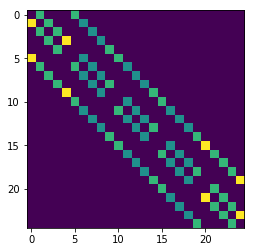

In [6]:
dx = 5
dy = 5

K = dx*dy

st = np.array(range(K)).reshape(dx,dy)

# transition matrix: p(h_{t+1} | h_t)
transition_prob = np.zeros((K, K)) # [new old]

for x in range(dx):
    for y in range(dy):       
        if validgridposition(x-1,y,dx,dy):
            transition_prob[st[x-1,y],st[x,y]] = 1
        if validgridposition(x+1,y,dx,dy):
            transition_prob[st[x+1,y],st[x,y]] = 1
        if validgridposition(x,y-1,dx,dy):
            transition_prob[st[x,y-1],st[x,y]] = 1
        if validgridposition(x,y+1,dx,dy):
            transition_prob[st[x,y+1],st[x,y]] = 1

transition_prob = transition_prob / transition_prob.sum(axis=0)

plt.imshow(transition_prob)
plt.show()

In [7]:
np.random.seed(1)

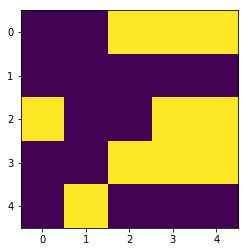

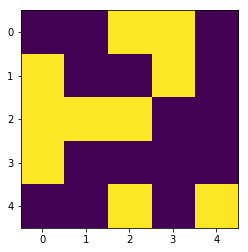

In [8]:
v1_prob = 0.1*np.ones((K,))
v2_prob = 0.1*np.ones((K,))

idx1 = np.random.permutation(K)[0:10]
idx2 = np.random.permutation(K)[0:10]

v1_prob[idx1] = 0.9
v2_prob[idx2] = 0.9

plt.imshow(v1_prob.reshape(dx,dy))
plt.show()
plt.imshow(v2_prob.reshape(dx,dy))
plt.show()

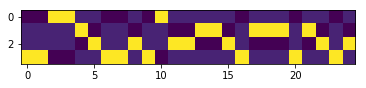

In [9]:
# observation probabilities p(v_t | h_t)

observation_prob = np.zeros((4, K))

observation_prob[0,:] = v1_prob*v2_prob         # p(v1=1|h)*p(v2=1|h)
observation_prob[1,:] = v1_prob*(1-v2_prob)     # p(v1=1|h)*p(v2=1|h)
observation_prob[2,:] = (1-v1_prob)*v2_prob     # p(v1=1|h)*p(v2=1|h)
observation_prob[3,:] = (1-v1_prob)*(1-v2_prob) # p(v1=1|h)*p(v2=1|h)

plt.imshow(observation_prob)
plt.show()

In [10]:
# generate data
np.random.seed(1)

T = 10

V = np.zeros((T,)).astype(int)
H = np.zeros((T,)).astype(int)

h = np.random.randint(0,K)
H[0] = int(h)
v = np.random.multinomial(1, observation_prob[:,H[0]]).nonzero()[0]
V[0] = int(v)

for t in range(1,T):
    H[t] = np.random.multinomial(1, transition_prob[:,H[t-1]]).nonzero()[0]
    V[t] = np.random.multinomial(1, observation_prob[:,H[t]]).nonzero()[0]

    
print(H)
print(V)

[ 5  0  5  6  1  2  7  8 13 14]
[0 1 2 3 3 0 3 0 1 1]


In [11]:
def visualize(hidden_state_idx, dx, dy):
    
    T = len(hidden_state_idx)
    K = dx*dy
    
    H = np.zeros((K,T))
    H[hidden_state_idx,range(T)] = 1
    
    K = H.shape[0]
    T = H.shape[1]
    
    A = H[:,0].reshape(dx, dy)
    
    for t in range(T)[1:]:
        A = np.hstack((A, 0.5*np.ones((dx,1)), H[:,t].reshape(dx, dy)))
        
    plt.imshow(A, cmap='gray')
    plt.show()    

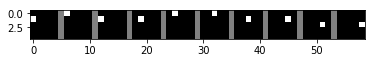

In [12]:
visualize(H, dx, dy)

In [13]:
from pystruct.inference import inference_dispatch
from pystruct.utils import make_grid_edges

pairwise = np.log(transition_prob.T + 1e-10) # [K K]
unaries = np.log(observation_prob[V,:] + 1e-10) # [T K]
edges = make_grid_edges(unaries.reshape(1, T, K))

# decoding
H_decoded = inference_dispatch(unaries, pairwise, edges, inference_method='max-product') 

print(H_decoded)

[5 0 5 0 1 2 1 2 3 4]


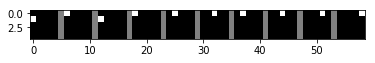

In [14]:
visualize(H_decoded, dx, dy)

Рассмотрим задачу поиска наиболее вероятной последовательности - $H_{MAP}$. 

$$p(H|X) = \frac{p(X, H)}{p(X)}$$

$$H_{MAP} = \arg \max_H p(H|X) = \arg \max_H p(X,H)$$

Эта задача сводится к более общей задаче поиска пути с минимальной стоимостью в графе специальной структуры (*minimum cost path in the multistage graph*), подобном тому, который изображен на рисунке: 
<img src="http://4.bp.blogspot.com/-bWTM86O7UIM/UYpaSyqLL9I/AAAAAAAAANE/jY_UY1gYmmY/s1600/multistage+graph.jpg">

Пусть каждому узлу соответствует "стоимость" (cost) - некоторое вещественное число. Необходимо найти путь (маршрут) от крайнего левого узла (красный) к крайнему правому (зеленый) с минимальной стоимостью. Стоимость пути есть сумма стоимостей узлов, которые содержит этот путь.

$$ S_{t,k} = U_{t,k} + \max_m [S_{t-1,m} + P_{k,m}]$$

где $U_{t,k} = \log p(x_t | h_t = k)$, $P_{k,m} = \log p(h_t = k | h_{t-1} = m)$

In [15]:
def viterbi_decoding(observation, obs_prob, trans_prob, p0):
# max-product
#
# input:
#   observation:          1 x T, sequence
#   trans_prob :          K x K, transition matrix, a_ij = Prb(h_j|h_i)
#   obs_prob   :          K x M, emission matrix, b_ij = Prb(v_j|h_i)
#   p0         :          K x 1, prior probabilities
#
# output:
#   decode_seq :          1 x T, sequence    

    K, M = obs_prob.shape[0], obs_prob.shape[1]
    T = len(observation)    

    decode_seq = np.zeros((T,)).astype(np.int)
    
    max_state = np.zeros((K, T))
    cost = np.zeros((K, T))    
    
    cost[:,0] = np.log(p0) + np.log(obs_prob[:,observation[0]])
    for t in range(1,T):
        d = cost[:, t-1] + np.log(trans_prob)
        max_state[:, t] = np.argmax(d.T, axis=0)
        cost[:, t] = np.log(obs_prob[:, observation[t]]) + np.max(d.T, axis=0)
        
    decode_seq[T-1] = np.argmax(cost[:, T-1])
    for t in range(T-2,-1,-1):
        decode_seq[t] = max_state[decode_seq[t+1], t+1]

    return decode_seq        

[5 0 5 0 1 2 1 2 3 4]


/home/alexey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


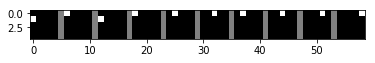

In [16]:
states = viterbi_decoding(V, observation_prob.T, transition_prob.T, np.ones((K,))/K)
print(states)
visualize(states, dx, dy)